# Sandbox for looking at output of trained UResNet 

In [1]:
import os,sys,time
import ROOT
from ROOT import std
from larcv import larcv
import numpy as np

# torch
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F

# Our model definition
from uresnet import UResNet



GPUMODE=False

%matplotlib notebook
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.12/04


In [2]:
# Set GPU ID

torch.cuda.device(0)

## Setup Network

In [3]:
# create instance
net = UResNet(inplanes=16,input_channels=1,num_classes=3)

numclasses = 4 # (bg, shower, track, noise)                                                                                                                                                  
net.conv13 = nn.Conv2d(net.nkernels, numclasses, 1, stride=1, padding=0, bias=True )
if GPUMODE:
    net.cuda()

In [4]:
# load weights
#weightfile="v1/run1/checkpoint.1000th.tar"
weightfile="checkpoint.2000th.tar"

checkpoint = torch.load( weightfile )
net.load_state_dict(checkpoint["state_dict"])


## Setup Image IO

In [5]:
# Define IO Class

# Segment Image Data Class
# we expect LArCV1Dataset to fill this object
class SegData:
    def __init__(self):
        self.dim = None
        self.images = None # adc image
        self.labels = None # labels
        self.weights = None # weights
        return

    def shape(self):
        if self.dim is None:
            raise ValueError("SegData instance hasn't been filled yet")
        return self.dim

# Data interface
class LArCV1Dataset:
    def __init__(self, name, cfgfile ):
        # inputs
        # cfgfile: path to configuration. see test.py.ipynb for example of configuration
        self.name = name
        self.cfgfile = cfgfile
        return
      
    def init(self):
        # create instance of data file interface
        self.io = larcv.ThreadDatumFiller(self.name)
        self.io.configure(self.cfgfile)
        self.nentries = self.io.get_n_entries()
        self.io.set_next_index(0)
        print "[LArCV1Data] able to create ThreadDatumFiller"
        return
        
    def getbatch(self, batchsize):
        self.io.batch_process(batchsize)
        time.sleep(0.1)
        itry = 0
        while self.io.thread_running() and itry<100:
            time.sleep(0.01)
            itry += 1
        if itry>=100:
            raise RuntimeError("Batch Loader timed out")
        
        # fill SegData object
        data = SegData()
        dimv = self.io.dim() # c++ std vector through ROOT bindings
        self.dim     = (dimv[0], dimv[1], dimv[2], dimv[3] )
        self.dim3    = (dimv[0], dimv[2], dimv[3] )

        # numpy arrays
        data.np_images  = np.zeros( self.dim,  dtype=np.float32 )
        data.np_labels  = np.zeros( self.dim3, dtype=np.int )
        data.np_weights = np.zeros( self.dim3, dtype=np.float32 )
        data.np_images[:]  = larcv.as_ndarray(self.io.data()).reshape(    self.dim  )[:]
        data.np_labels[:]  = larcv.as_ndarray(self.io.labels()).reshape(  self.dim3 )[:]
        data.np_weights[:] = larcv.as_ndarray(self.io.weights()).reshape( self.dim3 )[:]
        data.np_labels[:] += -1
        
        # pytorch tensors
        data.images = torch.from_numpy(data.np_images)
        data.labels = torch.from_numpy(data.np_labels)
        data.weight = torch.from_numpy(data.np_weights)
        #if GPUMODE:
        #    data.images.cuda()
        #    data.labels.cuda(async=False)
        #    data.weight.cuda(async=False)


        # debug values
        #print "max label: ",np.max(data.labels)
        #print "min label: ",np.min(data.labels)
        
        return data

In [8]:
# write configuration file
testcfg = """ThreadDatumFillerTest: {

  Verbosity:    2
  EnableFilter: false
  RandomAccess: true
  UseThread:    false 
  InputFiles:   ["/media/hdd1/larbys/ssnet_cosmic_retraining/raw/ssnet_retraining_049998.root"]
  ProcessType:  ["SegFiller"]
  ProcessName:  ["SegFiller"]

  IOManager: {
    Verbosity: 2
    IOMode: 0
    ReadOnlyTypes: []
    ReadOnlyNames: []
  }
    
  ProcessList: {
    SegFiller: {
      # DatumFillerBase configuration
      Verbosity: 2
      ImageProducer:     "adc"
      LabelProducer:     "label"
      WeightProducer:    "weight"
      # SegFiller configuration
      Channels: [2]
      SegChannel: 2
      EnableMirror: false
      EnableCrop: false
      ClassTypeList: [0,2,1,3]
      ClassTypeDef:  [0,1,2,3,0,0,0,0,0,0]
    }
  }
}
"""
    
with open("segfiller_test.cfg",'w') as fvalid:
    print >> fvalid,testcfg
    
io = LArCV1Dataset("ThreadDatumFillerTest","segfiller_test.cfg" )
io.init()

[LArCV1Data] able to create ThreadDatumFiller
 setting verbosity 2
    [NORMAL]  <ThreadDatumFillerTest::configure> IOManager configuration will be ignored...
    [NORMAL]  <ThreadDatumFillerTestProcessDriver::configure> Instantiating Process ID=0 Type: SegFiller w/ Name: SegFiller


## Run Network

In [9]:
# Get batch
batch = io.getbatch(1)

    [NORMAL]  <ThreadDatumFillerTestIOManager::prepare_input> Opening a file in READ mode: /media/hdd1/larbys/ssnet_cosmic_retraining/raw/ssnet_retraining_049998.root
    [NORMAL]  <ThreadDatumFillerTestIOManager::initialize> Prepared input with 110 entries...


In [10]:
# convert images into pytorch variables, then pass to net

if GPUMODE:
    img_var = torch.autograd.Variable(batch.images.cuda())
else:
    img_var = torch.autograd.Variable(batch.images)
out_var = net(img_var)

In [11]:
# turn output into labels (transfer back from gpu if necesary)

out_np = out_var.data.cpu().numpy()
decision_np = np.argmax( out_np, axis=1 )


# Plotting

In [12]:
# function for plotting side-by-side

def showImgAndLabels(image2d,label2d,weight2d):
    # Dump images
    fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(10,10), facecolor='w')
    ax0.imshow(image2d,  interpolation='none', cmap='jet', origin='lower')
    ax1.imshow(label2d,  interpolation='none', cmap='jet', origin='lower',vmin=0., vmax=3.1)
    ax2.imshow(weight2d, interpolation='none', cmap='jet', origin='lower',vmin=0., vmax=3.1)
    ax0.set_title('Data',fontsize=20,fontname='Georgia',fontweight='bold')
    #ax0.set_xlim(xlim)
    #ax0.set_ylim(ylim)
    ax1.set_title('Label',fontsize=20,fontname='Georgia',fontweight='bold')
    #ax1.set_xlim(xlim)
    #ax1.set_ylim(ylim)
    ax2.set_title('Network Out',fontsize=20,fontname='Georgia',fontweight='bold')
    plt.show()

<IPython.core.display.Javascript object>


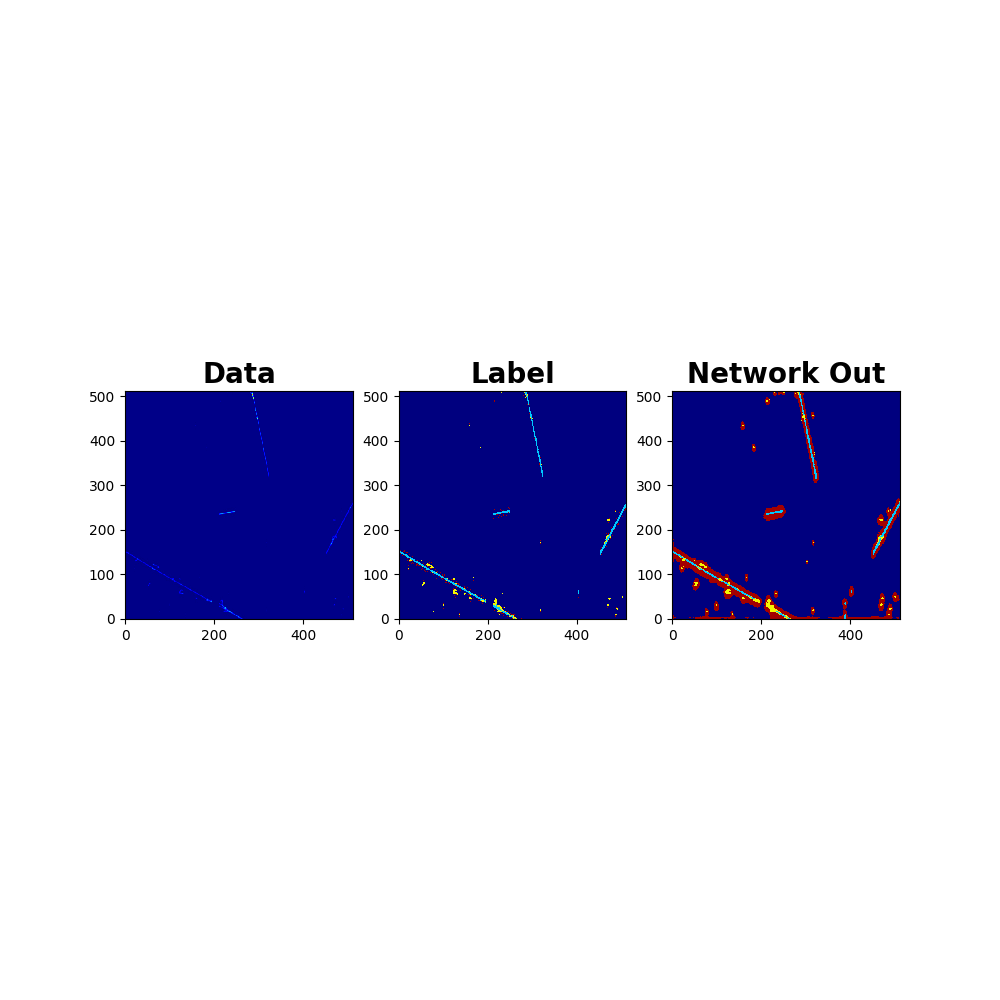

In [13]:
for ibatch in range(out_var.shape[0]):
    img_np = batch.images.cpu().numpy()[ibatch,0,:,:]
    labels = batch.labels.cpu().numpy()[ibatch,:,:]
    decision = decision_np[ibatch,:,:]
    showImgAndLabels(img_np,labels,decision)